# Subsampler examples

## Packages and modules

In [1]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint
from scipy.ndimage.filters import uniform_filter1d
from numpy.random import normal
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
#from statsmodels.tsa.arima_model import 

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [3]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
from algorithms.uniform_subsampler import *
from algorithms.queries import *
from algorithms.size_optimizer import *

## AR(1)

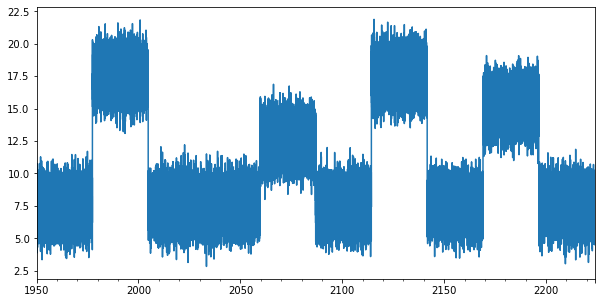

In [7]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.5])
ma = np.array([1])
time_series = ArmaProcess(-ar,ma)
time_series_values = time_series.generate_sample(n)

#Altered means
time_series_values[:] += 7.5
time_series_values[10000:20000] += 10
time_series_values[40000:50000] += 5
time_series_values[60000:70000] += 10
time_series_values[80000:90000] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


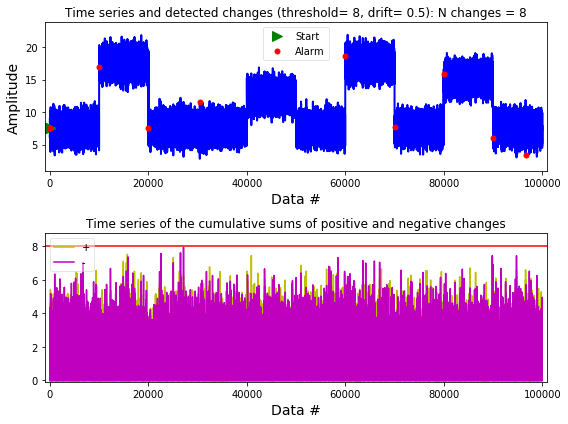

Interval size:  10000
Relative sample size:  1.9 %
----*----
Interval size:  10000
Relative sample size:  1.9 %
----*----
Interval size:  10447
Relative sample size:  2.49 %
----*----
Interval size:  29553
Relative sample size:  0.85 %
----*----
Interval size:  10000
Relative sample size:  2.3 %
----*----
Interval size:  10000
Relative sample size:  2.5 %
----*----
Interval size:  10001
Relative sample size:  2.3 %
----*----
Interval size:  6613
Relative sample size:  3.63 %
----*----
Interval size:  3386
Relative sample size:  7.38 %
----*----
Done


In [8]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 8, 0.5, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,10,10,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

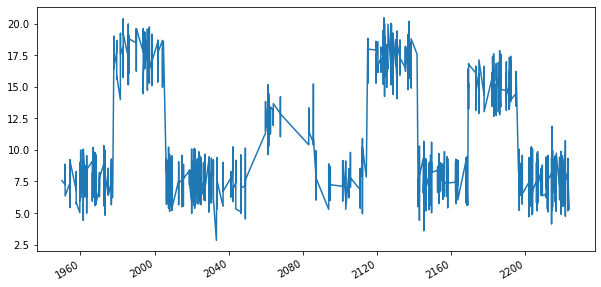

In [10]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [11]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.25)

In [12]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  9992
EB subsample size:  17433
Uniform subsample size:  10002


In [13]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('D').mean()
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

### Query evaluations

In [14]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', series[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', series[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

Interpolation for 57th value: 

Real value:  8.68548939694994
Empirical Bernstein:  7.404396477238354
Uniform sampler:  6.180671577355259
Online Sampler: 7.530808120355643
------------

Interpolation for 17400 value: 

Real value:  18.79627500197767
Empirical Bernstein:  17.485390326572254
Uniform sampler:  17.33899055102011
Online Sampler: 16.637855561260412
------------

Interpolation for 1003 value: 

Real value:  6.451885792610232
Empirical Bernstein:  6.629635941894352
Uniform sampler:  6.042651169708374
Online Sampler: 6.7562459334966904
------------

Interpolation for 77802 value: 

Real value:  9.339599059910261
Empirical Bernstein:  7.019035880700813
Uniform sampler:  7.931777228236438
Online Sampler: 7.527959583649889
------------



In [15]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

Euclidean distance: 

Empirical Bernstein:  448.68185405700495
Uniform:  460.5907608322591
Online Sampler: 
 547.4678471972412
------------ 

DTW distance: 

Empirical Bernstein:  103905.57066258359
Uniform:  105846.60993760414
Online Sampler: 
 118328.8853684401
------------



In [16]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.8945177691289582
lag 1:  0.9468583532817596
Empirical Bernstein: 
lag 0:  0.011744859073290205
lag 1:  -0.009978451695206388
Uniform: 
lag 0:  0.9272608686515595
lag 1:  0.9271506324919441
Online Sampler:
lag 0:  0.8934875550378664
lag 1:  0.9266246636262251
------------ 



In [19]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3018543244490455
Uniform:  0.03821655171619104
Online Sampler: 
 0.020259899756661398
------------ 



## AR(2)

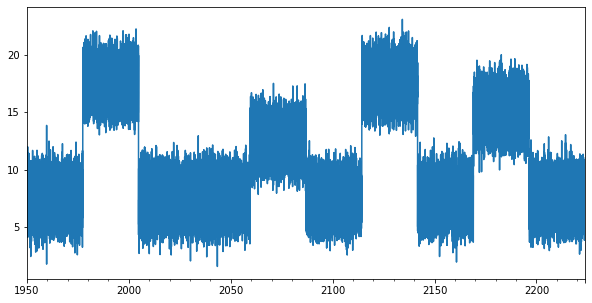

In [23]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5])
ma = np.array([1])
time_series = ArmaProcess(-ar,ma)
time_series_values = time_series.generate_sample(n)

#Altered means
time_series_values[:] += 7.5
time_series_values[10000:20000] += 10
time_series_values[40000:50000] += 5
time_series_values[60000:70000] += 10
time_series_values[80000:90000] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


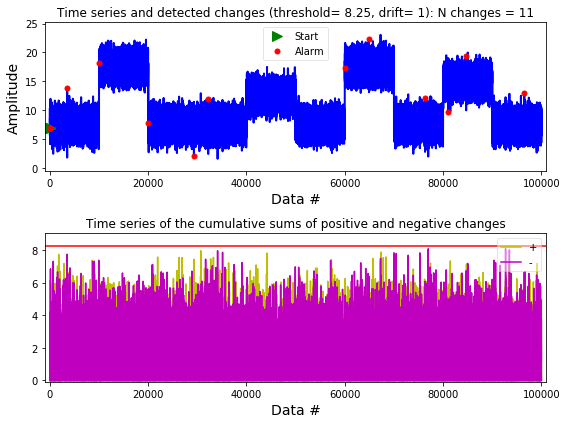

Interval size:  3526
Relative sample size:  5.67 %
----*----
Interval size:  6474
Relative sample size:  3.09 %
----*----
Interval size:  10000
Relative sample size:  2.2 %
----*----
Interval size:  9306
Relative sample size:  2.9 %
----*----
Interval size:  2912
Relative sample size:  9.27 %
----*----
Interval size:  27782
Relative sample size:  0.94 %
----*----
Interval size:  4927
Relative sample size:  5.07 %
----*----
Interval size:  11409
Relative sample size:  2.19 %
----*----
Interval size:  4748
Relative sample size:  5.27 %
----*----
Interval size:  3615
Relative sample size:  6.64 %
----*----
Interval size:  11822
Relative sample size:  1.95 %
----*----
Interval size:  3479
Relative sample size:  6.9 %
----*----
Done


In [41]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 8.25, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,10,10,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

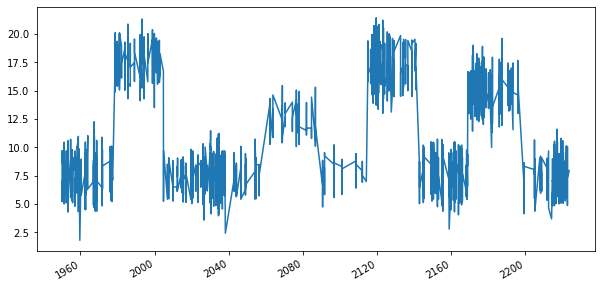

In [42]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [43]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.1)

In [44]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  18266
EB subsample size:  17357
Uniform subsample size:  20002


In [46]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('D').mean()
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

### Query evaluation

In [47]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', series[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', series[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

Interpolation for 57th value: 

Real value:  8.599673029767843
Empirical Bernstein:  4.618641202524981
Uniform sampler:  6.206063639622313
Online Sampler: 8.685302462565623
------------

Interpolation for 17400 value: 

Real value:  15.716568259128287
Empirical Bernstein:  19.092056142877446
Uniform sampler:  17.74439090554473
Online Sampler: 18.507186936451482
------------

Interpolation for 1003 value: 

Real value:  6.807261444849854
Empirical Bernstein:  8.95802001865792
Uniform sampler:  7.759909090760351
Online Sampler: 7.581585470699807
------------

Interpolation for 77802 value: 

Real value:  9.368591829420438
Empirical Bernstein:  9.368591829420438
Uniform sampler:  5.446752802039404
Online Sampler: 7.883110192784741
------------



In [48]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

Euclidean distance: 

Empirical Bernstein:  528.4906629403317
Uniform:  531.5155999768666
Online Sampler: 
 615.1903208096994
------------ 

DTW distance: 

Empirical Bernstein:  123827.07218119675
Uniform:  124101.72878374284
Online Sampler: 
 139313.97389354592
------------



In [55]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.8609609430706618
lag 1:  0.895268640654749
Empirical Bernstein: 
lag 0:  -0.0034002891612165947
lag 1:  -0.0014725262399461494
Uniform: 
lag 0:  0.9034297803013618
lag 1:  0.9045776576537214
Online Sampler:
lag 0:  0.8473962160249381
lag 1:  0.8624365593773496
------------ 



In [57]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.245497916573557
Uniform:  0.04347711965177596
Online Sampler: 
 0.035523898727909155
------------ 



## ARMA(3,1)

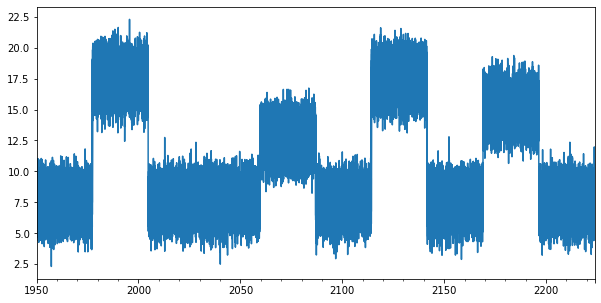

In [23]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5,0.25])
ma = np.array([1,0.5])
time_series = ArmaProcess(-ar,ma)
time_series_values = time_series.generate_sample(n)

#Altered means
time_series_values[:] += 7.5
time_series_values[10000:20000] += 10
time_series_values[40000:50000] += 5
time_series_values[60000:70000] += 10
time_series_values[80000:90000] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


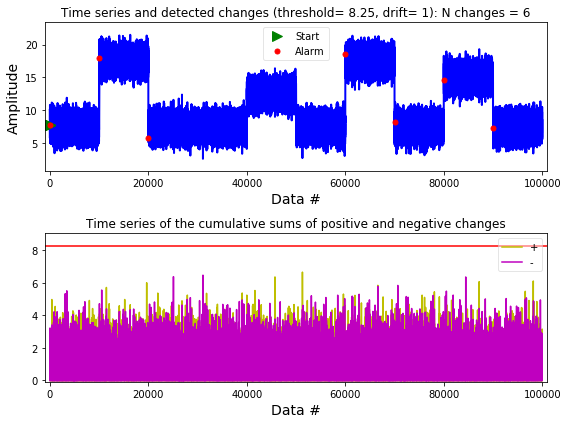

Interval size:  10000
Relative sample size:  1.9 %
----*----
Interval size:  10000
Relative sample size:  1.9 %
----*----
Interval size:  40000
Relative sample size:  0.6 %
----*----
Interval size:  10000
Relative sample size:  2.1 %
----*----
Interval size:  10000
Relative sample size:  2.4 %
----*----
Interval size:  10000
Relative sample size:  2.1 %
----*----
Interval size:  10000
Relative sample size:  2.3 %
----*----
Done


In [5]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 8.25, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,10,10,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

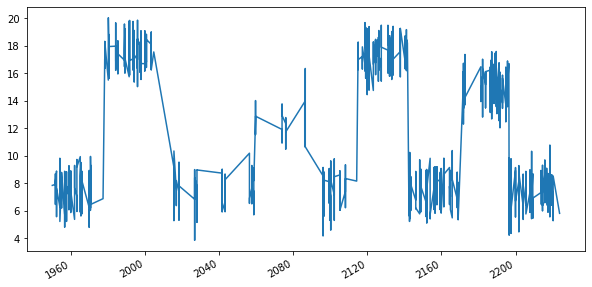

In [6]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [7]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.25)

In [8]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  5846
EB subsample size:  4890
Uniform subsample size:  5885


In [9]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('D').mean()
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

### Query evaluation

In [10]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', series[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', series[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

Interpolation for 57th value: 

Real value:  6.194383711689553
Empirical Bernstein:  8.563623568950268
Uniform sampler:  7.619508522050248
Online Sampler: 7.845949421948141
------------

Interpolation for 17400 value: 

Real value:  17.48505942599811
Empirical Bernstein:  17.624694304553625
Uniform sampler:  17.86386952513959
Online Sampler: 16.871831271268668
------------

Interpolation for 1003 value: 

Real value:  8.137358466646505
Empirical Bernstein:  7.441287361783452
Uniform sampler:  8.137358466646505
Online Sampler: 7.280883578713726
------------

Interpolation for 77802 value: 

Real value:  7.766655955962161
Empirical Bernstein:  8.85405554695179
Uniform sampler:  7.9271011021673585
Online Sampler: 8.918724147263127
------------



In [11]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

Euclidean distance: 

Empirical Bernstein:  450.02061255509904
Uniform:  444.8460594372518
Online Sampler: 
 658.4111091200001
------------ 

DTW distance: 

Empirical Bernstein:  104992.89592790004
Uniform:  102062.90740106805
Online Sampler: 
 115052.414356429
------------



In [12]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 3, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 3, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 3, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 3, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9251605218059186
lag 1:  0.9143423140613257
lag 2:  0.9409936847125934
Empirical Bernstein: 
lag 0:  -0.02017875180729926
lag 1:  -0.008490234234762022
lag 2:  0.01472288841318567
Uniform: 
lag 0:  0.9309380502216356
lag 1:  0.9292982541122365
lag 2:  0.927022801227386
Online Sampler:
lag 0:  0.933015871224706
lag 1:  0.9143771125196671
lag 2:  0.9163804779481185
------------ 



In [13]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 3, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 3, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 3, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.6134633068363706
Uniform:  0.021266065991576717
Online Sampler: 
 0.025836363379058168
------------ 



## ARMA(2,2)

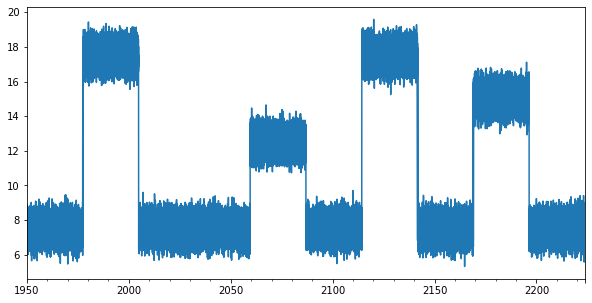

In [11]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5])
ma = np.array([1,0.5,0.25])
#time_series = ArmaProcess(ar,ma)
time_series_values = arma_generate_sample(-ar,ma,n,sigma)

#Altered means
time_series_values[:] += 7.5
time_series_values[10000:20000] += 10
time_series_values[40000:50000] += 5
time_series_values[60000:70000] += 10
time_series_values[80000:90000] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


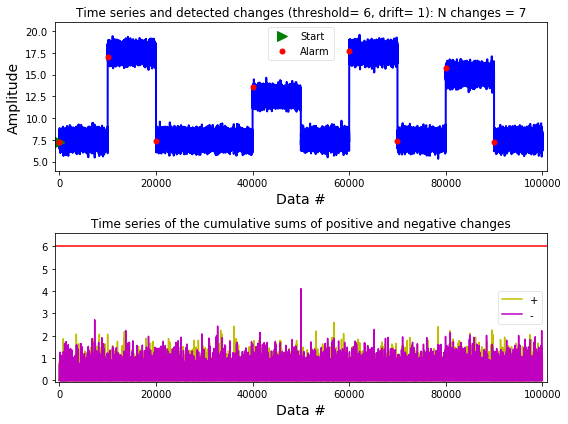

Interval size:  10000
Relative sample size:  1.6 %
----*----
Interval size:  10000
Relative sample size:  1.8 %
----*----
Interval size:  20000
Relative sample size:  1.3 %
----*----
Interval size:  20000
Relative sample size:  1.2 %
----*----
Interval size:  10000
Relative sample size:  2.2 %
----*----
Interval size:  10000
Relative sample size:  2.4 %
----*----
Interval size:  10000
Relative sample size:  2.2 %
----*----
Interval size:  10000
Relative sample size:  2.3 %
----*----
Done


In [12]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 6, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,10,10,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

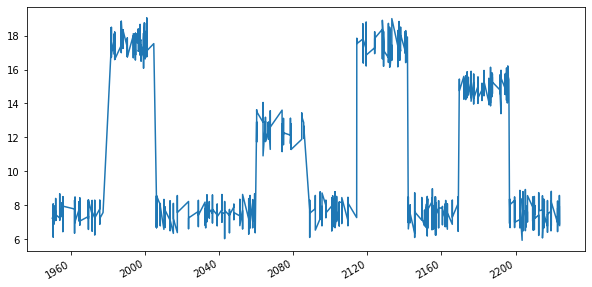

In [13]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [14]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.25)

In [15]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  7612
EB subsample size:  12896
Uniform subsample size:  7695


In [16]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('D').mean()
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

### Query evaluation

In [17]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', series[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', series[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

Interpolation for 57th value: 

Real value:  7.490857308705309
Empirical Bernstein:  6.999809882073767
Uniform sampler:  7.2193811504954395
Online Sampler: 7.273074440267866
------------

Interpolation for 17400 value: 

Real value:  17.8545485423421
Empirical Bernstein:  17.649086928915274
Uniform sampler:  17.054168878521846
Online Sampler: 17.729118996377178
------------

Interpolation for 1003 value: 

Real value:  6.675835170904057
Empirical Bernstein:  7.776956445768585
Uniform sampler:  7.230122624634688
Online Sampler: 7.353174807477153
------------

Interpolation for 77802 value: 

Real value:  7.295916275130844
Empirical Bernstein:  7.016413544390409
Uniform sampler:  7.562904065742824
Online Sampler: 6.744441457341461
------------



In [18]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

Euclidean distance: 

Empirical Bernstein:  207.95745339242998
Uniform:  212.79213470556135
Online Sampler: 
 377.68834698855625
------------ 

DTW distance: 

Empirical Bernstein:  47479.615984038835
Uniform:  48620.52564689691
Online Sampler: 
 58126.45488949081
------------



In [19]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9803664752815009
lag 1:  0.9823724449544196
Empirical Bernstein: 
lag 0:  0.017367889442068015
lag 1:  -0.0017209856510295677
Uniform: 
lag 0:  0.9825016782816702
lag 1:  0.9806263608817863
Online Sampler:
lag 0:  0.9713924518614886
lag 1:  0.961267514946691
------------ 



In [20]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.376882767881692
Uniform:  0.0027582424550128904
Online Sampler: 
 0.022933625247091843
------------ 



In [22]:
#Verifying Arma models
#model = ARMA(time_series_values, (2, 2)).fit(trend='nc', disp=0)
model_uniform_sample = ARMA(uniform_sample, (2, 2)).fit(trend='nc', disp=0)
#model_eb_sample = ARMA(eb_sample, (2, 2)).fit(trend='nc', disp=0)
model_online_sample = ARMA(online_subsample, (2, 2)).fit(trend='nc', disp=0)

In [24]:
#Parameters
#ar = np.array([1,0.75,0.5])
#ma = np.array([1,0.5,0.25])
#print('original model: ', model.params)
print('uniform sample model: ', model_uniform_sample.params)
#print('eb model: ', model_eb_sample.params)
print('online model: ', model_online_sample.params)

uniform sample model:  ar.L1.y    0.151623
ar.L2.y    0.847751
ma.L1.y    0.247212
ma.L2.y   -0.500951
dtype: float64
online model:  ar.L1.y    0.155512
ar.L2.y    0.841702
ma.L1.y    0.490394
ma.L2.y   -0.327219
dtype: float64


## Varying block size

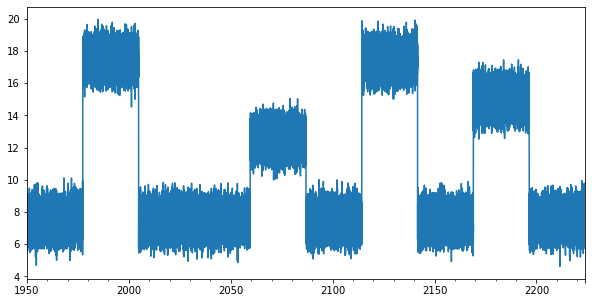

In [4]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5])
ma = np.array([1])
#time_series = ArmaProcess(ar,ma)
time_series_values = arma_generate_sample(-ar,ma,n,sigma)

#Altered means
time_series_values[:] += 7.5
time_series_values[10000:20000] += 10
time_series_values[40000:50000] += 5
time_series_values[60000:70000] += 10
time_series_values[80000:90000] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


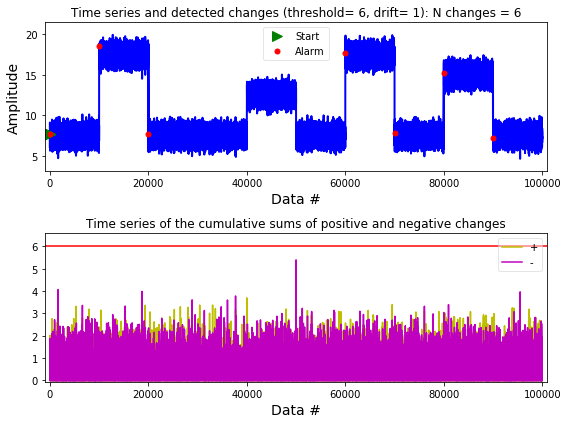

Interval size:  10000
Relative sample size:  2.25 %
----*----
Interval size:  10000
Relative sample size:  2.25 %
----*----
Interval size:  40000
Relative sample size:  0.81 %
----*----
Interval size:  10000
Relative sample size:  2.75 %
----*----
Interval size:  10000
Relative sample size:  3.0 %
----*----
Interval size:  10000
Relative sample size:  2.75 %
----*----
Interval size:  10000
Relative sample size:  3.0 %
----*----
Done


In [5]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 6, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,14,25,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

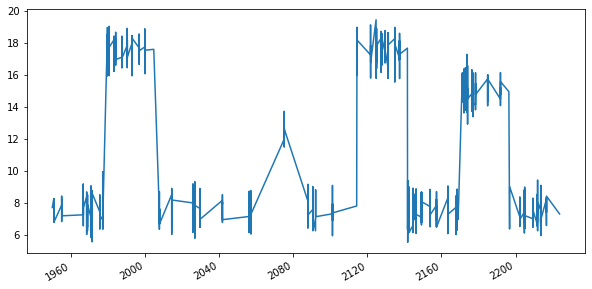

In [6]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [7]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.25)

In [8]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  7411
EB subsample size:  15279
Uniform subsample size:  7695


In [10]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9633813676401103
lag 1:  0.9723695532953119
Empirical Bernstein: 
lag 0:  0.006706026826078584
lag 1:  0.0031786818277194
Uniform: 
lag 0:  0.9733445634823238
lag 1:  0.9717258735990711
Online Sampler:
lag 0:  0.9649283693298405
lag 1:  0.9640489573680441
------------ 



In [11]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3618218139895377
Uniform:  0.009983966894058345
Online Sampler: 
 0.008463186800070919
------------ 



In [12]:
#Verifying Arma models
#model = ARMA(time_series_values, (2, 2)).fit(trend='nc', disp=0)
model_uniform_sample = ARMA(uniform_sample, (2, 0)).fit(trend='nc', disp=0)
#model_eb_sample = ARMA(eb_sample, (2, 2)).fit(trend='nc', disp=0)
model_online_sample = ARMA(online_subsample, (2, 0)).fit(trend='nc', disp=0)

In [13]:
#Parameters
#ar = np.array([1,0.75,0.5])
#print('original model: ', model.params)
print('uniform sample model: ', model_uniform_sample.params)
#print('eb model: ', model_eb_sample.params)
print('online model: ', model_online_sample.params)

uniform sample model:  ar.L1.y    0.529360
ar.L2.y    0.468633
dtype: float64
online model:  ar.L1.y    0.511161
ar.L2.y    0.486088
dtype: float64


## Simplest possible model

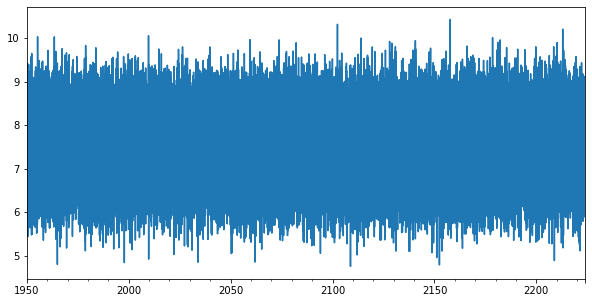

In [14]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5])
ma = np.array([1])
#time_series = ArmaProcess(ar,ma)
time_series_values = arma_generate_sample(-ar,ma,n,sigma)
time_series_values[:] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


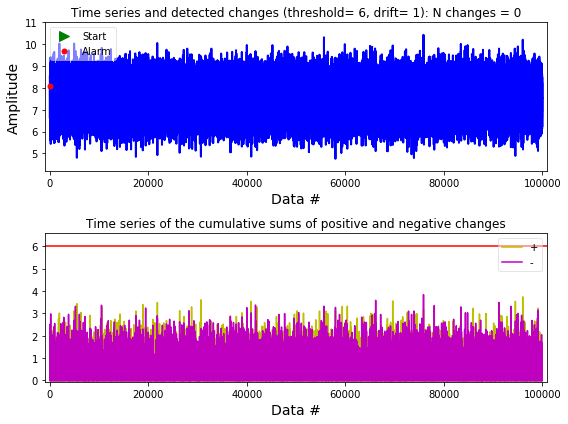

Interval size:  100000
Relative sample size:  0.8 %
----*----
Done


In [20]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 6, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,14,50,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

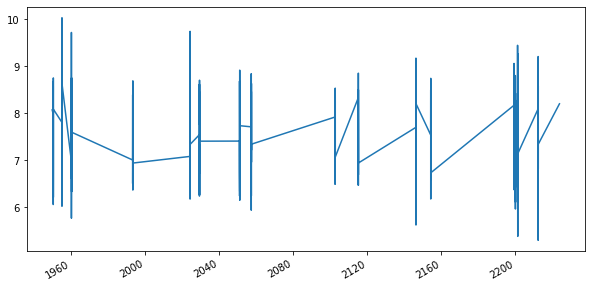

In [21]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [22]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.25)

In [23]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  802
EB subsample size:  737
Uniform subsample size:  809


In [25]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  -0.49683454514556336
lag 1:  -0.12902388950271057
Empirical Bernstein: 
lag 0:  0.027628710137285573
lag 1:  -0.003400354966058403
Uniform: 
lag 0:  -0.00023683258517036306
lag 1:  -0.04053362132639441
Online Sampler:
lag 0:  -0.5055038790995932
lag 1:  -0.10360654039443137
------------ 



In [26]:
#Verifying Arma models
model = ARMA(time_series_values, (2,0)).fit(trend='nc', disp=0)
model_uniform_sample = ARMA(uniform_sample, (2, 0)).fit(trend='nc', disp=0)
model_eb_sample = ARMA(eb_sample, (2,0)).fit(trend='nc', disp=0)
model_online_sample = ARMA(online_subsample, (2, 0)).fit(trend='nc', disp=0)

In [27]:
#Parameters
#ar = np.array([1,0.75,0.5])
print('original model: ', model.params)
print('uniform sample model: ', model_uniform_sample.params)
print('eb model: ', model_eb_sample.params)
print('online model: ', model_online_sample.params)

original model:  [0.37493866 0.6206537 ]
uniform sample model:  ar.L1.y    0.518570
ar.L2.y    0.477551
dtype: float64
eb model:  ar.L1.y    0.514545
ar.L2.y    0.481631
dtype: float64
online model:  ar.L1.y    0.364322
ar.L2.y    0.631488
dtype: float64


## Second simple model

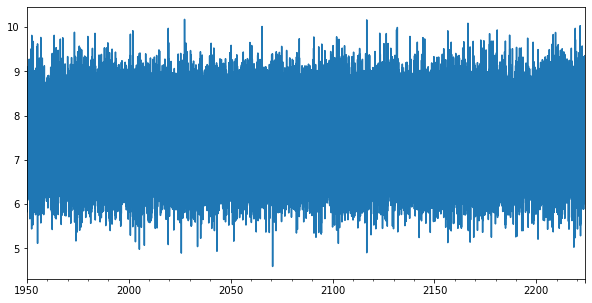

In [28]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

ar = np.array([1,0.75,0.5, 0.25])
ma = np.array([1])
#time_series = ArmaProcess(ar,ma)
time_series_values = arma_generate_sample(-ar,ma,n,sigma)
time_series_values[:] += 7.5

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(time_series_values, index =tidx)
series.plot(figsize=(10, 5))

breakpoint started
subsampler started


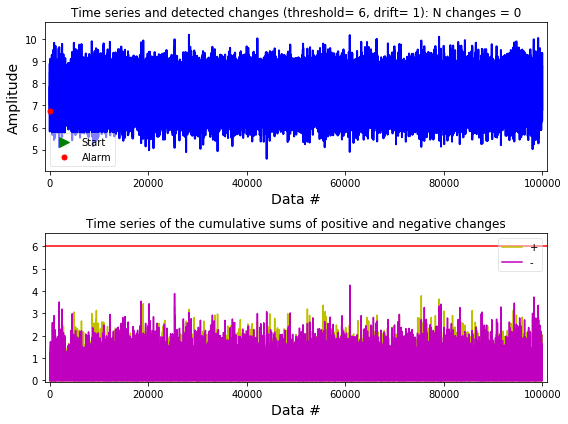

Interval size:  100000
Relative sample size:  0.35 %
----*----
Done


In [33]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (series, queue, 6, 1, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,5,50,series, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

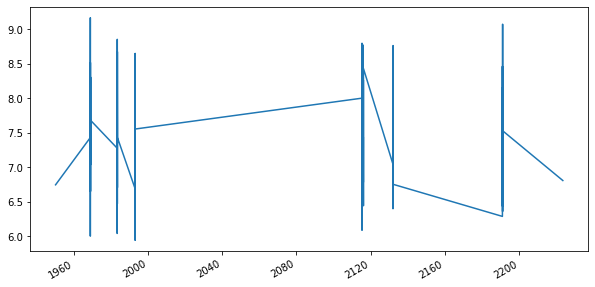

In [34]:
#Subsample data
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [35]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(series, online_subsample_size, 10, error = 0.1)

In [36]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  352
EB subsample size:  328
Uniform subsample size:  355


In [37]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  -0.49991817665011884
lag 1:  -0.00231761572930093
Empirical Bernstein: 
lag 0:  0.022789289796234135
lag 1:  -0.017402887528517662
Uniform: 
lag 0:  -0.08784278630668658
lag 1:  0.037537080211709234
Online Sampler:
lag 0:  -0.4806870335599857
lag 1:  -0.02352250890123992
------------ 



In [38]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 3, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 3, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 3, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  0.5256495949978324
Uniform:  0.4145350536767385
Online Sampler: 
 0.07346975685813294
------------ 



In [39]:
#Verifying Arma models
model = ARMA(time_series_values, (3,0)).fit(trend='nc', disp=0)
model_uniform_sample = ARMA(uniform_sample, (3, 0)).fit(trend='nc', disp=0)
model_eb_sample = ARMA(eb_sample, (3,0)).fit(trend='nc', disp=0)
model_online_sample = ARMA(online_subsample, (3, 0)).fit(trend='nc', disp=0)

In [40]:
#Parameters
#ar = np.array([1,0.75,0.5, 0.25])
print('original model: ', model.params)
print('uniform sample model: ', model_uniform_sample.params)
print('eb model: ', model_eb_sample.params)
print('online model: ', model_online_sample.params)

original model:  [-0.00138305  0.49707607  0.50253264]
uniform sample model:  ar.L1.y    0.255278
ar.L2.y    0.411390
ar.L3.y    0.330812
dtype: float64
eb model:  ar.L1.y    0.373142
ar.L2.y    0.318004
ar.L3.y    0.306432
dtype: float64
online model:  ar.L1.y   -0.011251
ar.L2.y    0.469559
ar.L3.y    0.540019
dtype: float64
